# Exercise: probabilistic neural networks

Andrei Tiberiu Alexandru - ata36@cam.ac.uk

There are two main sections: text answers with snippets of code and full code underlying the answers.

Table of contents:
1. [Answers](#Answers)  
    1.1 [Question (a)](#Question(a))  
    1.2 [Question (b)](#Question(b))  
    1.3 [Question (c)](#Question(c))  
    1.4 [Question (d)](#Question(d))  
    1.5 [Question (e)](#Question(e))  
    1.6 [Question (f)](#Question(f))  
2. [Full code](#Full-code)

# Answers

## Question(a)

Ribbon-plot of homoscedastic model:

In [ ]:
mu_x = simple_wiggle.mu(x).detach().numpy()
sigma = simple_wiggle.sigma.item()

plt.plot(xkcd.x, mu_x)
plt.fill_between(xkcd.x, (mu_x-1.96*sigma).reshape(31,), (mu_x+1.96*sigma).reshape(31,), alpha=0.2)

Ribbon plot of heteroscedastic model. Because $\sigma$ varies, the width of the ribbon varies depending on how the model fits the data. Re-training the model results in a differently shaped ribbon. 

In some regions, there is 0 variance, which means the model has perfectly fit the data points in that region. I think that training until we perfectly overfit would result in the ribbon 'disappearing' from the plot as it overlaps with the plotted line.

In [ ]:
mu_x = heteroscedastic_wiggle.mu(x).detach().numpy()
sigma = heteroscedastic_wiggle.sigma(x).detach().numpy()

plt.plot(xkcd.x, mu_x)
plt.fill_between(xkcd.x, (mu_x-1.96*sigma).reshape(31,), (mu_x+1.96*sigma).reshape(31,), alpha=0.2)

## Question(b)
### Maximum possible training likelihood

The maximum average log-likelihood of the dataset should be given by the empirical distribution - the average log-likelihood under a perfectly overfitted model: $$\log Pr_X(x_1, \dots, x_n) = \sum_x q_x \log q_x $$
where
$$q_x =  \frac{\text{# of occurrences of x}}{\text{total number of samples}} $$

Let's implement this:

In [ ]:
def q(x):
    _, counts = np.unique(x, return_counts=True)
    return counts/x.shape[0]

In [ ]:
q_x = q(x)

np.sum(q_x * np.log(q_x))

We can also check this mathematically. There are 31 unique data points in our tensor $x$, which means they all have likelihood $1 \over 31$. So $$\sum_x q_x log q_x = 31 \times \frac{1}{31} \log \Big(\frac{1}{31} \Big) = \log \Big(\frac{1}{31} \Big) = -3.4339$$

I'm uncertain that this is correct, because during training the average log-likelihood is higher (i.e. a negative number closer to 0) than -3.43.

### Likelihood v. epochs

Both models are trained for 50,000 epochs. The log-likelihoods for each are saved every 100 epochs and plotted below:

In [ ]:
epochs = np.arange(1, 50000, 100)

plt.plot(epochs, heteroscedastic_training_likelihood)
plt.plot(epochs, simple_training_loglik)

It looks as though the dips in likelihood occur when the optimisation algorithm tries larger values for the weights of the network that generates $\sigma$ (initialised in `self.sigmapre = Wiggle()`). Larger weights result in a larger $\sigma$, so the resulting distribution has higher variance. This means that the distribution fits the data worse, so the likelihood decreases. When $\sigma$ is not dependent on $x$, its value is more stable, mostly between 1.6 and 1.4.

In one of the runs, a dip occurred from log-likelihood -1.046 to -1.539; at those values, the mean of the vector $\sigma(x)$ was 1.1963 and 1.5876, respectively. When $\sigma$ is allowed to depend on $x$, the variance of the model can take on more extreme values.

---

## Question(c)

### Reconstructed images

In [ ]:
new_images = []

for image in showr:
    
    # Add the original image.
    new_images.append(image.detach().numpy()[0][0])
    
    # Generate 3 reconstructions of the image.
    for i in range(3):
        mu, sigma = simple_vae(image)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma*epsilon
        new_image = simple_vae.f(z)
        new_images.append(new_image.detach().numpy()[0][0])

cols, rows = 4, 4
fig = plt.figure(figsize=(10, 10))

for i in range(1, cols*rows + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(new_images[i-1])
plt.show()

### Varying amounts of noise

In [ ]:
image, _ = mnist[35508]
image = image.reshape((1, 1, 28, 28)) # Must be [Bx1x28x28].
mu, sigma = autoencoder(image)

# TODO: should this have some K*noise*sigma?
# Sample 5 Zs with different noise and generate images from them.
z = [mu + torch.randn_like(sigma)*sigma for _ in range(5)]
new_images = [autoencoder.f(z_i) for z_i in z]
fig = plt.figure(figsize=(10, 10))

for i in range(len(new_images)):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(new_images[i].detach().numpy()[0][0])

plt.axis('off')
plt.show()

### 12 random images

To generate 12 random images, we take 12 samples from distribution $\tilde Z$ and decode them.

In [ ]:
z_samples = [torch.rand(4) for _ in range(12)]
generated_images = [autoencoder.f(z_i) for z_i in z_samples]

fig = plt.figure(figsize=(10, 10))

for i in range(len(generated_images)):
    fig.add_subplot(1, 12, i+1)
    plt.imshow(generated_images[i].detach().numpy()[0][0])
plt.axis('off')
plt.show()

### Interpolating two images

To interpolate two images, we first encode them into two latent variables $\tilde{Z}_1, \tilde{Z}_2$. Then, we interpolate in the latent space by generating a new latent variable $\tilde{Z}_* = \lambda \tilde{Z}_1 + (1-\lambda) \tilde{Z}_2$. $\lambda$ is chosen randomly in the interval $[0, 1)$.

In [ ]:
(img1, _), (img2, _) = mnist[28001], mnist[43876]
img1 = img1.reshape((1, 1, 28, 28))
img2 = img2.reshape((1, 1, 28, 28))
mu1, sigma1 = autoencoder(img1)
mu2, sigma2 = autoencoder(img2)
z1 = mu1 + torch.randn_like(sigma1)
z2 = mu2 + torch.randn_like(sigma2)

# Generate 10 z* interpolated between z1 and z2.
interpolated_vars = []
for _ in range(10):
    coef = random.random()
    interpolated_vars.append(z1 + coef*(z2-z1))

# Add the first of the original images.
new_images = [img1]
for z_i in interpolated_vars:
    new_images.append(autoencoder.f(z_i))
new_images.append(img2)

# Plot all images.
fig = plt.figure(figsize=(10, 10))

for i in range(len(new_images)):
    fig.add_subplot(1, 12, i+1)
    plt.imshow(new_images[i].detach().numpy()[0][0])
plt.axis('off')
plt.show()

## Question(d)

### Monte-Carlo Integration with more than one sample

Given that $\tilde Z^{(i, \phi)} = \mu_\phi + \sigma_\phi * \epsilon$, where $\epsilon \sim \mathcal{N}(0, I_d)$, to sample multiple values of $\tilde Z$ we need to sample $\epsilon$ multiple times. For each sample, we compute the log-likelihood through `f.loglik(x, z)`. We then average this likelihood across the number of samples we took, controlled by `num_samples`. 

In practice, we trade off more accurate estimates of the sampling distribution $\tilde Z$ through increased  number of samples against the time the model takes to train. 

In [ ]:
def loglik_lb(self, batch_num, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)

        ll = 0
        num_samples = 1
        for _ in range(num_samples):
            ε = torch.randn_like(σ)
            ll += self.f.loglik(x, z=μ+σ*ε)
        ll /= num_samples

        # Store the image with the lowest likelihood across all batches.
        if torch.min(ll) < self.min_likelihood[0]:
            self.min_likelihood = torch.min(ll), torch.argmin(ll) + batch_num*100

        # Store the image with the highest likelihood across all batches.
        if torch.max(ll) < self.max_likelihood[0]:
            self.max_likelihood = torch.max(ll), torch.argmax(ll) + batch_num*100

        # Sum up all likelihoods to find likelihood of dataset.
        return ll - kl

### Likely and unlikely images

TODO: Keep more than just the least likely and most likely image. See what those look like. 

In [ ]:
likely, _ = mnist[72]
unlikely, _ = mnist[1618]

fig = plt.figure(figsize=(5, 5))

fig.add_subplot(1, 2, 1)
plt.imshow(unlikely[0])
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(likely[0])
plt.axis('off')

plt.show()

## Question(e)

Training the autoencoder with 20 dimensions is easy, we just initialise it with `d = 20` and train as we normally would:

In [ ]:
autoencoder = GaussianEncoder(BernoulliImageGenerator(d=20))
optimizer = optim.Adam(autoencoder.parameters())
epoch = 0

while epoch < 10:
    # ...
    pass

The sensible way to evaluate two models is to train them on the same data, and evaluate both of them on the same holdout data set. How do we decide which portion of the entire data to keep as the holdout data set? We've discussed taking the 20% most 'extreme' data points, but what is extreme in this case?

## Question(f)

The question is a problem setup for the conditional variational autoencoder, introduced in [Sohn et al., 2015](https://proceedings.neurips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf). The key idea is to condition the generated output on not only the image $x_i$ but also its label $y_i$. 

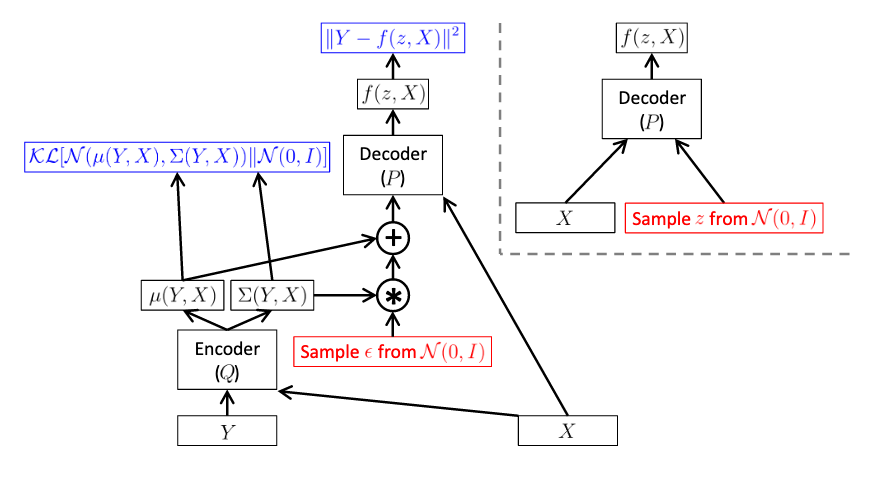

In the above figure from [Doersch, 2016](https://arxiv.org/pdf/1606.05908.pdf) of the architecture of the CVAE, $Y$ corresponds to our MNIST image and $X$ corresponds to its label.

### Perfect sampling distribution
The perfect sampling distribution for a VAE is derived from the lower-bound log-likelihood formula: 
$$\mathcal{L}_{lb}(\theta, \phi) = \sum_{i=1}^n \mathbb{E}_{z \sim \tilde Z^{(i, \phi)}} \Bigg[\log Pr_X(x_i | Z=q(g_\phi(x_i), F); \theta) \frac{Pr_Z(z)}{Pr_{\tilde Z^{(i, \phi)}}(z)} \Bigg]$$
We want to choose the sampling distribution $\tilde Z$ such that its likelihood $Pr_{\tilde Z^{(i, \phi)}}(z)$ looks like the Bayesian posterior of $Z$, which is:
$$Pr_{\tilde Z}(z) = \kappa Pr_Z(x_i | Z=z; \theta)Pr_Z(z)$$ where $\kappa$ is some constant.

For the conditional VAE, we additionally need to condition on the label $Y=y$:
$$\mathcal{L}_{lb}(\theta, \phi) = \sum_{i=1}^n \mathbb{E}_{z \sim \tilde Z^{(i, \phi)}} \Bigg[\log Pr_X(x_i | Z=q(g_\phi(x_i), F), Y=y; \theta) \frac{Pr_Z(z)}{Pr_{\tilde Z^{(i, \phi)}}(z)} \Bigg]$$
which yields the following perfect sampling distribution:
$$Pr_{\tilde Z}(z) = \kappa Pr_Z(x_i | Z=z, Y=y; \theta)Pr_Z(z)$$

In essence, this is saying that in order to choose a good sampling distribution $\tilde Z$, we need to factor in the label $y$. We do so by passing in the image and the label into the encoder at the same time.

### Generate four styles of digits
The main modifications to the `GaussianEncoder` and `BernoulliImageGenerator` classes used in the previous questions are to feed the image and label into the encoder, and latent variable and label into the decoder, at the same time. 

For the encoder, we first one-hot encode the label, e.g. `y = [3]` into a vector of shape `1x10` where the 3rd entry is 1, and all others are 0. Then, we apply a linear transformation to bring it to dimensions `1x784`, which we reshape to `1x28x28`. Once the label has this shape, we stack it on top of its respective image (shape `1x28x28`) as an extra channel. The 'superimposed' image and label have shape `2x28x28`. (Actually, because Pytorch works on batches, the dimension of the input would be `Bx2x28x28`.)

For the decoder, we simply stack the `1x10` one-hot encoded label on top of the `1xD` latent variable, where $D$ is the number of dimensions of the latent space.

The approach is inspired by [this](https://github.com/AntixK/PyTorch-VAE/blob/master/models/cvae.py) implementation, though it should be possible to encode the label in other ways.

Once the model is trained, generating stylistically similar images of different digits is easy. We sample a single $\tilde Z$ and vary the label that we use to decode it:

In [ ]:
y = [5, 3, 9, 1]
y_encoded = one_hot_encode(y, 10)
all_images = []

# Sample four different Z~, decode each using four digits.
for _ in range(4):
    z = torch.randn(1,4)
    all_images.append([autoencoder.f(z, y_i.unsqueeze(1).T).detach().numpy() for y_i in y_encoded])

# Plot results.
fig = plt.figure(figsize=(10, 10))
for j in range(len(all_images)):
    for i in range(len(all_images[j])):
        fig.add_subplot(len(all_images[j]), len(all_images), 4*j+(i+1))
        plt.imshow(all_images[j][i][0][0])

---
# Full code

## Linear models for (a)-(b)

### Imports and data loading

In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch

import random

In [ ]:
url = 'https://www.cl.cam.ac.uk/teaching/2122/DataSci/data/xkcd.csv'
xkcd = pandas.read_csv(url)

plt.scatter(xkcd.x, xkcd.y)

### Define simple (homoscedastic) model

In [ ]:
class Wiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )
    def forward(self, x):
        return self.f(x)
    
class RWiggle(nn.Module):
    """Y_i ~ N(f(x_i), sigma2)"""
    def __init__(self):
        super().__init__()
        self.mu = Wiggle()
        self.sigmapre = nn.Parameter(torch.tensor(1.0))
    @property
    def sigma(self):
         return torch.nn.functional.softplus(self.sigmapre)
    def forward(self, y, x):
        sigma2 = torch.pow(self.sigma, 2)
        return - 0.5*torch.log(2*np.pi*sigma2) - torch.pow(y - self.mu(x), 2) / (2*sigma2)

### Train model

In [ ]:
x = torch.tensor(xkcd.x, dtype=torch.float)[:, None]
y = torch.tensor(xkcd.y, dtype=torch.float)[:, None]

simple_wiggle = RWiggle()
epoch = 0
optimizer = optim.Adam(simple_wiggle.parameters())

# Store the log-likelihood of the dataset every 100 epochs
# so we can plot it against epochs and compare with the 
# heteroscedastic model.
simple_training_loglik = []

with Interruptable() as check_interrupted:
    while epoch < 50000:
        check_interrupted()
        optimizer.zero_grad()
        loglikelihood = torch.mean(simple_wiggle(y, x))
        (-loglikelihood).backward()
        optimizer.step()
        epoch += 1
        if epoch % 100 == 0:
            simple_training_loglik.append(loglikelihood.item())

### Heteroscedastic model

In [ ]:
class HeteroscedasticRWiggle(nn.Module):
    """Y_i ~ N(f(x_i), f(x_i)^2)"""
    def __init__(self):
        super().__init__()
        self.mu = Wiggle()
        self.sigmapre = Wiggle()
    def sigma(self, x):
         return torch.nn.functional.softplus(self.sigmapre(x))
        
    def forward(self, y, x):
        sigma2 = torch.pow(self.sigma(x), 2)
        return - 0.5*torch.log(2*np.pi*sigma2) - torch.pow(y - self.mu(x), 2) / (2*sigma2)

In [ ]:
heteroscedastic_wiggle = HeteroscedasticRWiggle()
epoch = 0
optimizer = optim.Adam(heteroscedastic_wiggle.parameters())
heteroscedastic_training_likelihood = []

with Interruptable() as check_interrupted:
    while epoch < 50000:
        check_interrupted()
        optimizer.zero_grad()
        loglikelihood = torch.mean(heteroscedastic_wiggle(y, x))
        (-loglikelihood).backward()
        optimizer.step()
        epoch += 1
        if epoch % 100 == 0:
            heteroscedastic_training_likelihood.append(loglikelihood.item())

---
## Variational autoencoders for (c)-(f)

### VAE with expanded sampling

In [ ]:
class BernoulliImageGeneratorExpandedSampling(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1, 2, 3))


class GaussianEncoderExpandedSampling(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )
        self.max_likelihood = (0, 0)
        self.min_likelihood = (0, 0)

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, batch_num, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)

        ll = 0
        num_samples = 1
        for _ in range(num_samples):
            ε = torch.randn_like(σ)
            ll += self.f.loglik(x, z=μ+σ*ε)
        ll /= num_samples

        if torch.min(ll) < self.min_likelihood[0]:
            self.min_likelihood = torch.min(ll), torch.argmin(ll) + batch_num*100

        if torch.max(ll) < self.max_likelihood[0]:
            self.max_likelihood = torch.max(ll), torch.argmax(ll) + batch_num*100

        # Sum up all likelihoods to find likelihood of dataset.
        return ll - kl

### Taking a holdout dataset and evaluating models on it